# plotOutputs_FluxPIHM_2024.ipynb

## Original version by Andrew Virebicher, Spring 2022. Uses functions in pihm_utils
## Updated Fall 2024 by gcng

Plots the following outputs:
- Outlet discharge time series
- Time-averaged soil moisture
- Time-averaged evapotranspiration

### Recall about figures: 
If you want figures to "pop out," add: 
%matplotlib inline

To make it go back to appearing inside Jupyter lab, add:
%matplotlib qt 

In [19]:
import pandas as pd
test = pd.read_csv("input/Chimborazo_land_cover/Chimborazo_test.csv", delimiter = ' ')
test['LC'] = 22
test.to_csv('test.att', sep = '\t', index = False)

In [173]:
try:
    import pihm
except ImportError:
    print("Your computer does not have the PIHM-utils module, so this script will try to download it")
    
    # Fall 2024: added the below, based on PIHM_visualization.ipynb in MM-PIHM GitHub 
    # (Note that Spyder shows a warning in editor, but it may work. Otherwise, 
    #  run the below line in Python console first, or run 'pip install 
    #  pihm-utils' in terminal on Linux/Mac)
    !pip install pihm-utils
    
    import pihm
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
import os
import seaborn as sns

In [20]:
def change_file_names(dir, old_name, new_name):
    os.chdir(dir)
    for f in os.listdir(dir):
        if new_name in f:
            print(f'file {f} already has correct name')
            continue
        else:
            new_f = f.replace(old_name, new_name)
            os.rename(f, new_f)
change_file_names("C:/Users/huan1428/Documents/esci5331_hydro_modeling/assignment_7/input/Chimborazo_climate_change", "Chimborazo", "Chimborazo_climate_change")


### Customize to your computer

In [1]:
#===== Directory containing the Flux-PIHM 'input' and 'output' directories =====#
pihm_directory = "C:/Users/huan1428/Documents/esci5331_hydro_modeling/assignment_7"
#=========================================================#

#===== ONLY the name of the specific sub-subdirectories in 'input' and 'output', NOT the full path =====#
input_folder_name = "Chimborazo_land_cover" # inside {pihm_directory}/input
output_folder_name = "Chimborazo_land_cover"  # inside {pihm_directory}/output
#============================================================================#

In [109]:
class PIHMData:
    def __init__(self, **params):
        self.sim_name = params.get('sim_name', None)
        self.mesh_info = params.get('mesh_info', {})
        self.simulation_time = params.get('simulation_time', None)
        self.outlet_discharge = params.get('outlet_discharge', None)
        self.discharge_units = params.get('discharge_units', None)
        self.canopy_evap = params.get('canopy_evap', None)
        self.soil_evap = params.get('soil_evap', None)
        self.total_transp = params.get('total_transp', None)
        self.et = self.canopy_evap + self.soil_evap + self.total_transp
        self.soil_moisture_layers = params.get('soil_moisture_layers', None)
        self.soil_moisture_avg = params.get('soil_moisture_avg', None)
    def set_name(self, name):
        self.sim_name = name

def load_mesh_data(sim_name, pihm_dir = "C:/Users/huan1428/Documents/esci5331_hydro_modeling/assignment_7"):
    num_elements, num_nodes, tri, x, y, zmin, zmax = pihm.read_mesh(pihm_dir, sim_name)
    num_rivers, from_nodes, to_nodes, outlets = pihm.read_river(pihm_dir, sim_name)
    lines = [[(x[node1], y[node1]), (x[node2], y[node2])] for (node1, node2) in zip(from_nodes, to_nodes)]
    river_lines = LineCollection(lines, linewidths=2, colors="black")
    mesh_info = {'num_elements' : num_elements, 
              'num_nodes' : num_nodes, 
              'tri' : tri, 
              'x' : x, 
              'y' : y, 
              'zmin': zmin, 
              'zmax': zmax,
              'lines' : lines,
              'river_lines' : river_lines}
    return mesh_info

def get_output_data(sim_name, pihm_dir = "C:/Users/huan1428/Documents/esci5331_hydro_modeling/assignment_7"):
    mesh_info = load_mesh_data(sim_name)
    soil_moisture_output_name = "smc"         # What are the letters in the file extension for the total soil moisture ? (Hint -- it looks like ###0, ###1, ... ###10)
    canopy_evaporation_output_name = "ec"    # These can all be found in the documentation
    soil_evaporation_output_name = "edir"
    total_transpiration_output_name = "ett"
    #===== Load the output data =====#
    print(f"Reading river discharge file...")
    simulation_time, river_discharge, _, discharge_units = pihm.read_output(pihm_dir, sim_name, sim_name, "river.flx1")   # River discharge
    outlet_discharge: np.ndarray = river_discharge[:,-1]

    print(f"Reading canopy evaporation file...")
    _, canopy_evaporation, _, canopy_evaporation_units = pihm.read_output(pihm_dir, sim_name, sim_name, canopy_evaporation_output_name)
    print(f"Reading soil evaporation file...")
    _, soil_evaporation, _, soil_evaporation_units = pihm.read_output(pihm_dir, sim_name, sim_name, soil_evaporation_output_name)
    print(f"Reading total transpiration file...")
    _, total_transpiration, _, total_transpiration_units = pihm.read_output(pihm_dir, sim_name, sim_name, total_transpiration_output_name)
    #
    # There are 10 soil moisture layers -- want the average over depth
    print(f"Reading soil moisture files...")
    soil_moisture_layers = []
    for i in range(0,11,1):
        _, layer, _, _ = pihm.read_output(pihm_dir, sim_name, sim_name, f"smc{i}")
        if layer.mean() >= 0.0:
            soil_moisture_layers.append(layer)

    ## Take the time-average of each of the outputs
    print(f"Processing canopy evaporation data...")
    canopy_evaporation_avg = np.mean(canopy_evaporation, axis = 0)
    print(f"Processing soil evaporation data...")
    soil_evaporation_avg = np.mean(soil_evaporation, axis = 0)
    print(f"Processing total transpiration data...")
    total_transpiration_avg = np.mean(total_transpiration, axis = 0)
    
    total_evapotranspiration_avg = canopy_evaporation_avg + soil_evaporation_avg + total_transpiration_avg
    
    soil_moisture_avg = np.zeros(mesh_info['num_elements'])
    print(f"Processing soil moisture data...")
    for layer in soil_moisture_layers:
        soil_moisture_avg += (1.0/11.0) * np.mean(layer, axis = 0)
    
    return PIHMData(sim_name = sim_name, 
                    mesh_info = mesh_info, 
                    soil_moisture_avg = soil_moisture_avg, 
                    simulation_time = simulation_time, 
                    outlet_discharge = outlet_discharge,
                    canopy_evap = canopy_evaporation_avg,
                    total_transp = total_transpiration_avg,
                    soil_evap = soil_evaporation_avg )


In [106]:
lc_data = get_output_data('Chimborazo_land_cover')
ctrl_data = get_output_data('Chimborazo')
cc_data = get_output_data('Chimborazo_climate_change')

Reading river discharge file...
Reading canopy evaporation file...
Reading soil evaporation file...
Reading total transpiration file...
Reading soil moisture files...
Processing canopy evaporation data...
Processing soil evaporation data...
Processing total transpiration data...
Processing soil moisture data...
Reading river discharge file...
Reading canopy evaporation file...
Reading soil evaporation file...
Reading total transpiration file...
Reading soil moisture files...
Processing canopy evaporation data...
Processing soil evaporation data...
Processing total transpiration data...
Processing soil moisture data...
Reading river discharge file...
Reading canopy evaporation file...
Reading soil evaporation file...
Reading total transpiration file...
Reading soil moisture files...
Processing canopy evaporation data...
Processing soil evaporation data...
Processing total transpiration data...
Processing soil moisture data...


## Enter files for what you want to plot

In [ ]:
def plot_outputs(plot_type, *pihm_data, **plot_config):
    n_plots = len(pihm_data) 
    nrow = plot_config.get('nrow', 1)
    print(nrow)
    ncol = plot_config.get('ncol', n_plots)
    figsize = plot_config.get('figsize', (4*ncol, 4*nrow))
    fig, ax = plt.subplots(nrow, ncol, figsize = figsize)
    subplot_titles = plot_config.get('subplot_titles', None)
    ymin = plot_config.get('ymin', None)
    ymax = plot_config.get('ymax', None)
    vmin = plot_config.get('vmin', None)
    vmax = plot_config.get('vmax', None)
    colormap = plot_config.get('colormap', 'seismic')
    figtitle = plot_config.get('figtitle', None)
    if plot_type == "discharge": 
        for i in range(len(pihm_data)): 
            data = pihm_data[i]
            x = data.simulation_time
            y = data.outlet_discharge
            try: 
                ax[i].plot(x,y)
                ax[i].set_xlabel("Simulation time")
                ax[i].set_ylabel(r"Discharge $\frac{m^3}{s}$")
                ax[i].set_ylim(ymin, ymax)
                ax[i].set_title(f"Outlet discharge, {subplot_titles[i]}")
            except: 
                ax.plot(x,y)
                ax.set_xlabel("Simulation time")
                ax.set_ylabel(r"Discharge $\frac{m^3}{s}$")
                ax.set_ylim(ymin, ymax)
                ax.set_title(f"Outlet discharge, {subplot_titles[i]}")
    elif plot_type == "soil":
        for i in range(len(pihm_data)): 
            data = pihm_data[i]
            x = data.mesh_info['x']
            y = data.mesh_info['y']
            tri = data.mesh_info['tri']
            soil_moisture_avg = data.soil_moisture_avg
            try: 
                mappable = ax[i].tripcolor(x, y, tri, facecolors=soil_moisture_avg, cmap=colormap, vmin = vmin, vmax = vmax, edgecolors="k")

                river_lines = data.mesh_info['river_lines']
                # ax[i].tripcolor(x,y,tri,facecolors = soil_moisture_avg, cmap = "jet", edgecolors = "k")
                ax[i].set_xlabel("UTM Easting")
                ax[i].set_ylabel("UTM Northing")
                ax[i].set_title(f"Average soil moisture, {subplot_titles[i]}")
                ax[i].add_collection(river_lines)
            except:
                mappable = ax.tripcolor(x, y, tri, facecolors=soil_moisture_avg, cmap=colormap, vmin = vmin, vmax = vmax,edgecolors="k")
                river_lines = data.mesh_info['river_lines']
                # ax[i].tripcolor(x,y,tri,facecolors = soil_moisture_avg, cmap = "jet", edgecolors = "k")
                ax.set_xlabel("UTM Easting")
                ax.set_ylabel("UTM Northing")
                ax.set_title(f"Average soil moisture, {subplot_titles[i]}")
                ax.add_collection(river_lines)
        try:
            cbar = plt.colorbar(mappable, ax=ax[n_plots-1], label=r"soil moisture ($\frac{m^3}{m^3}$)")
        except:
            cbar = plt.colorbar(mappable, ax=ax, label=r"soil moisture ($\frac{m^3}{m^3}$)")

    elif plot_type == "et":
        for i in range(len(pihm_data)): 
            data = pihm_data[i]
            x = data.mesh_info['x']
            y = data.mesh_info['y']
            tri = data.mesh_info['tri']
            var = data.et
            try:
                mappable = ax[i].tripcolor(x, y, tri, facecolors=var, cmap=colormap, vmin = vmin, vmax = vmax,edgecolors="k")
                river_lines = data.mesh_info['river_lines']
                ax[i].set_xlabel("UTM Easting")
                ax[i].set_ylabel("UTM Northing")
                ax[i].set_title(f"Average ET, {subplot_titles[i]}")
                ax[i].add_collection(river_lines)
            except: 
                mappable = ax.tripcolor(x, y, tri, facecolors=var, cmap=colormap,vmin = vmin, vmax = vmax, edgecolors="k")
                river_lines = data.mesh_info['river_lines']
                ax.set_xlabel("UTM Easting")
                ax.set_ylabel("UTM Northing")
                ax.set_title(f"Average ET, {subplot_titles[i]}")
                ax.add_collection(river_lines)  
        try:              
            cbar = plt.colorbar(mappable, ax=ax[n_plots-1], label=r"ET ($\frac{m}{s}$)")
        except:
            cbar = plt.colorbar(mappable, ax=ax, label=r"ET ($\frac{m}{s}$)")
    plt.tight_layout()
    if figtitle != None:
        plt.savefig(f"{figtitle}.png", bbox_inches = 'tight')


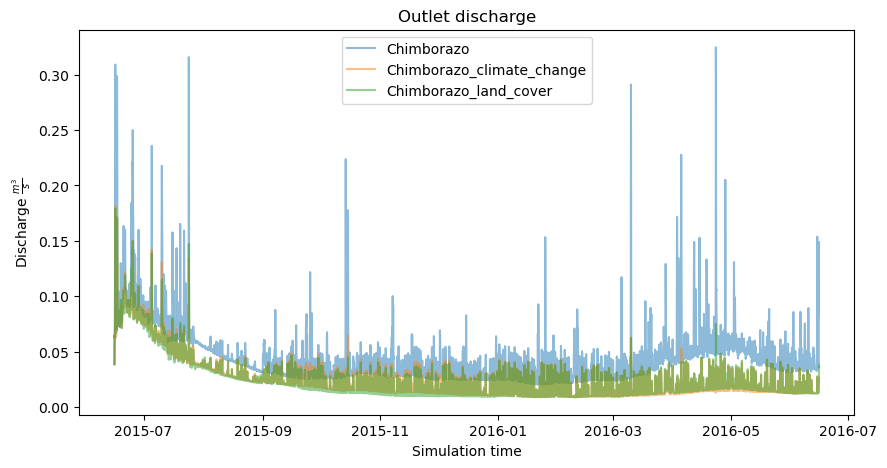

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
pihm_data = [ctrl_data, cc_data, lc_data]
subplot_titles = [ctrl_data.sim_name, cc_data.sim_name, lc_data.sim_name]
for i in range(len(pihm_data)): 
    data = pihm_data[i]
    x = data.simulation_time
    y = data.outlet_discharge
    sns.lineplot(x=x, y=y, ax = ax, label = subplot_titles[i], alpha = 0.5)
    ax.set_xlabel("Simulation time")
    ax.set_ylabel(r"Discharge $\frac{m^3}{s}$")
    ax.set_title(f"Outlet discharge")
plt.legend()
plt.savefig('figs/discharge_overlay.png', bbox_inches = 'tight')

3


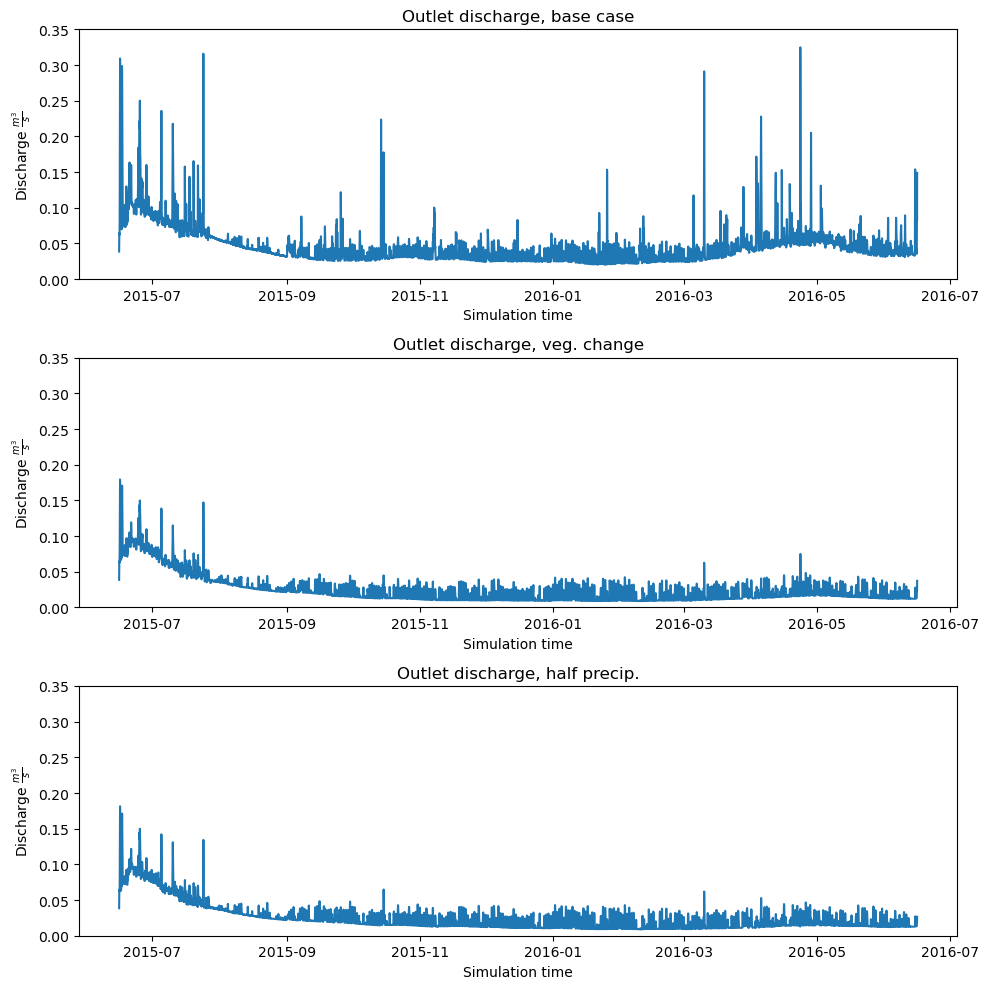

In [54]:
plot_outputs('discharge', ctrl_data, lc_data, cc_data, subplot_titles = ['base case','veg. change', 'half precip.'], nrow = 3, ncol = 1, figsize = (10, 10), ymin = 0, ymax = 0.35, figtitle = 'figs/discharge_compare')

In [174]:
def plot_output_diff( var, ctrl, *test, **plot_config):
    match var:
        case 'et':
            unit = 'm/s'
            fig_title = "Diff in avg. ET"
        case 'soil':
            unit = r'$\frac{m^3}{m^3}$'
            fig_title = "Diff in avg. soil moisture"
        case _:
            unit = ''
            fig_title = ''
    n_plots = len(test)
    fig, ax = plt.subplots(1, n_plots, figsize = (5*n_plots, 5))
    colormap = plot_config.get('colormap', 'viridis')
    fig_path = plot_config.get('fig_path', None)
    relative_diff = plot_config.get('relative_diff', False)
    pos_neg = plot_config.get('pos_neg', False)
    vmin = plot_config.get('vmin', None)
    vmax = plot_config.get('vmax', None)
    for i in range(len(test)):
        data = test[i]
        x = data.mesh_info['x']
        y = data.mesh_info['y']
        tri = data.mesh_info['tri']
        match var:
            case 'et':
                ctrl_vals = ctrl.et
                diff =  data.et - ctrl.et 
            case 'soil': 
                ctrl_vals = ctrl.soil_moisture_avg
                diff = data.soil_moisture_avg - ctrl.soil_moisture_avg
            case '_':
                diff = None
        if relative_diff:
            ctrl_vals = [x if x > 0 else 1e-20 for x in ctrl_vals]
            diff = diff/ctrl_vals * 100
            unit = '%'
        if pos_neg: 
            diff = [1 if x > 0 else - 1 if x < 0 else 0 for x in diff]
            unit = '+, -, or 0'
            colormap = ListedColormap(['blue', 'yellow', 'green'])
        mappable = ax[i].tripcolor(x, y, tri, facecolors=diff, cmap=colormap, vmin = vmin, vmax = vmax, edgecolors="k")
        river_lines = data.mesh_info['river_lines']
        # ax[i].tripcolor(x,y,tri,facecolors = soil_moisture_avg, cmap = "jet", edgecolors = "k")
        ax[i].set_xlabel("UTM Easting")
        ax[i].set_ylabel("UTM Northing")
        ax[i].set_title(f"{fig_title}, {data.sim_name}")
        ax[i].add_collection(river_lines)
    if pos_neg:
        cbar = plt.colorbar(mappable, ax=ax[n_plots-1], ticks = [-1, 0, 1], label=f"{fig_title}, {unit}")
    else:
        cbar = plt.colorbar(mappable, ax=ax[n_plots-1], label=f"{fig_title}, {unit}")
    plt.tight_layout()
    # ax[i].tripcolor(x,y,tri,facecolors = soil_moisture_avg, cmap = "jet", edgecolors = "k")
    if fig_path != None:
        plt.savefig(f'figs/diff_{fig_path}.png', bbox_inches = 'tight')

Reading river discharge file...
Reading canopy evaporation file...
Reading soil evaporation file...
Reading total transpiration file...
Reading soil moisture files...
Processing canopy evaporation data...
Processing soil evaporation data...
Processing total transpiration data...
Processing soil moisture data...
1


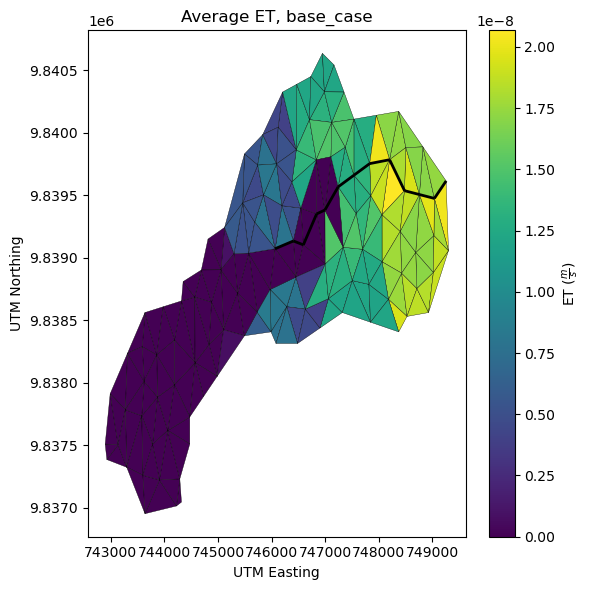

In [156]:
ctrl_data = get_output_data('Chimborazo')
# plot_outputs('soil', ctrl_data, colormap = 'RdBu', figsize = (6, 6), subplot_titles = ['base_case'], figtitle = 'figs/soil_moisture')
plot_outputs('et', ctrl_data, colormap = 'viridis', figsize = (6, 6), subplot_titles = ['base_case'], figtitle = 'figs/et')


In [ ]:
#output diff for soil
lc_data = get_output_data('Chimborazo_land_cover')
ctrl_data = get_output_data('Chimborazo')
cc_data = get_output_data('Chimborazo_climate_change')
plot_output_diff('soil', ctrl_data, cc_data, lc_data, relative_diff = True, colormap = 'viridis', vmin = -1, vmax = 7 fig_path = 'soil_compare')

In [ ]:
#output diff for et
lc_data = get_output_data('Chimborazo_land_cover')
ctrl_data = get_output_data('Chimborazo')
cc_data = get_output_data('Chimborazo_climate_change')
plot_output_diff('et', ctrl_data, cc_data, lc_data, relative_diff = True, colormap = 'viridis', vmin = -20, vmax = 150, fig_path = 'et_compare')

Reading river discharge file...
Reading canopy evaporation file...
Reading soil evaporation file...
Reading total transpiration file...
Reading soil moisture files...
Processing canopy evaporation data...
Processing soil evaporation data...
Processing total transpiration data...
Processing soil moisture data...
Reading river discharge file...
Reading canopy evaporation file...
Reading soil evaporation file...
Reading total transpiration file...
Reading soil moisture files...
Processing canopy evaporation data...
Processing soil evaporation data...
Processing total transpiration data...
Processing soil moisture data...
Reading river discharge file...
Reading canopy evaporation file...
Reading soil evaporation file...
Reading total transpiration file...
Reading soil moisture files...
Processing canopy evaporation data...
Processing soil evaporation data...
Processing total transpiration data...
Processing soil moisture data...


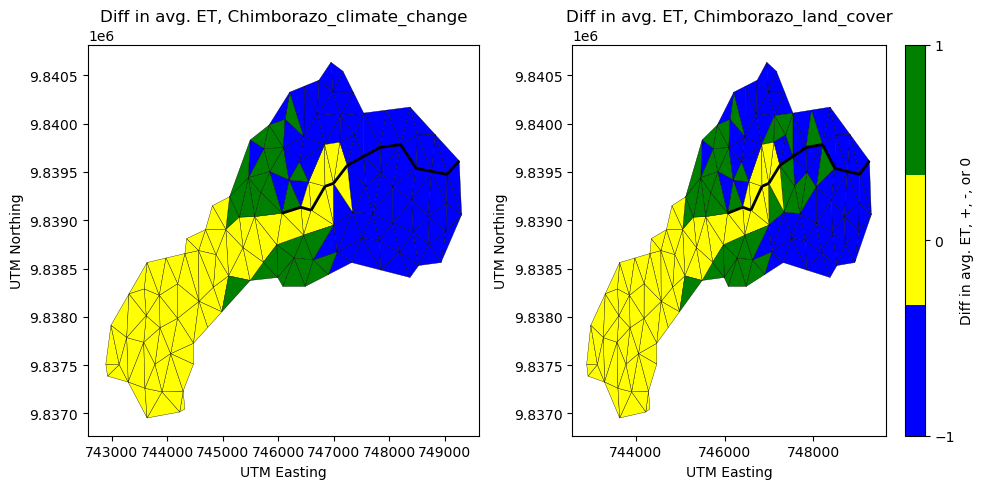

In [ ]:
#output diff sign for et
lc_data = get_output_data('Chimborazo_land_cover')
ctrl_data = get_output_data('Chimborazo')
cc_data = get_output_data('Chimborazo_climate_change')
plot_output_diff('et', ctrl_data, cc_data, lc_data, pos_neg = True, fig_path = 'et_compare_magnitude')

In [ ]:
lc_data = get_output_data('Chimborazo_land_cover')
ctrl_data = get_output_data('Chimborazo')
cc_data = get_output_data('Chimborazo_climate_change')
plot_output_diff('et', ctrl_data, lc_data, cc_data, relative_diff = True, colormap = 'plasma', vmin = -30, vmax = 175, fig_path = 'et_compare')

Reading river discharge file...
Reading canopy evaporation file...
Reading soil evaporation file...
Reading total transpiration file...
Reading soil moisture files...
Processing canopy evaporation data...
Processing soil evaporation data...
Processing total transpiration data...
Processing soil moisture data...
Reading river discharge file...
Reading canopy evaporation file...
Reading soil evaporation file...
Reading total transpiration file...
Reading soil moisture files...
Processing canopy evaporation data...
Processing soil evaporation data...
Processing total transpiration data...
Processing soil moisture data...
Reading river discharge file...
Reading canopy evaporation file...
Reading soil evaporation file...
Reading total transpiration file...
Reading soil moisture files...
Processing canopy evaporation data...
Processing soil evaporation data...
Processing total transpiration data...
Processing soil moisture data...
1


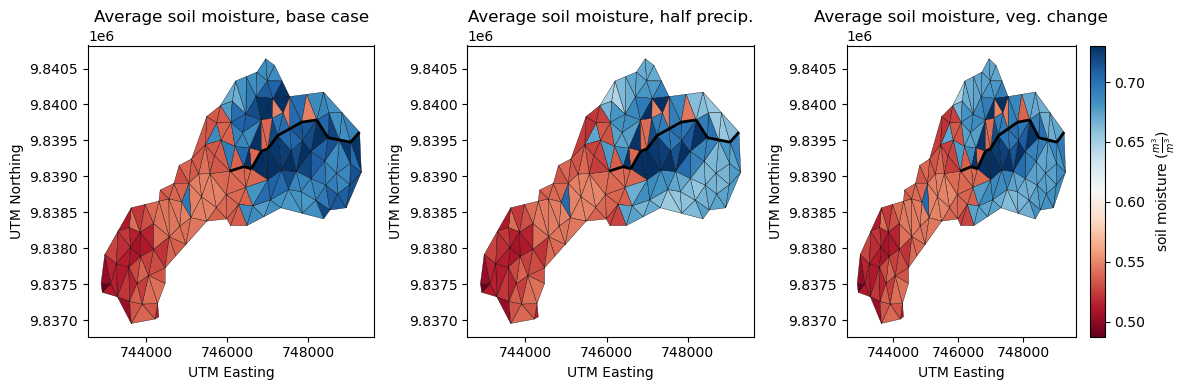

In [158]:
lc_data = get_output_data('Chimborazo_land_cover')
ctrl_data = get_output_data('Chimborazo')
cc_data = get_output_data('Chimborazo_climate_change')
plot_outputs('soil', ctrl_data, cc_data, lc_data, subplot_titles = ['base case','half precip.', 'veg. change'],colormap = 'RdBu', vmin = 0.45,vmax = 0.82, figtitle = 'figs/soil_moisture_compare')

Reading river discharge file...
Reading canopy evaporation file...
Reading soil evaporation file...
Reading total transpiration file...
Reading soil moisture files...
Processing canopy evaporation data...
Processing soil evaporation data...
Processing total transpiration data...
Processing soil moisture data...
Reading river discharge file...
Reading canopy evaporation file...
Reading soil evaporation file...
Reading total transpiration file...
Reading soil moisture files...
Processing canopy evaporation data...
Processing soil evaporation data...
Processing total transpiration data...
Processing soil moisture data...
Reading river discharge file...
Reading canopy evaporation file...
Reading soil evaporation file...
Reading total transpiration file...
Reading soil moisture files...
Processing canopy evaporation data...
Processing soil evaporation data...
Processing total transpiration data...
Processing soil moisture data...
1


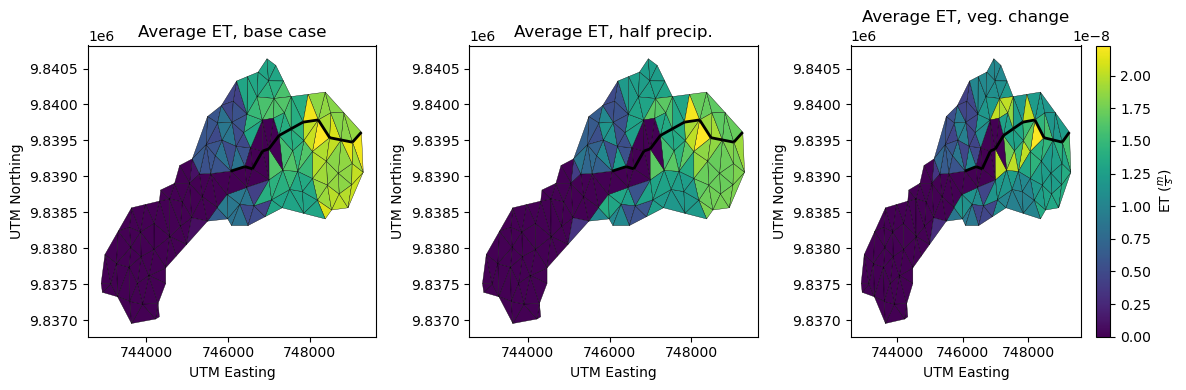

In [159]:
lc_data = get_output_data('Chimborazo_land_cover')
ctrl_data = get_output_data('Chimborazo')
cc_data = get_output_data('Chimborazo_climate_change')
plot_outputs('et', ctrl_data, cc_data, lc_data, subplot_titles = ['base case','half precip.', 'veg. change'], vmin = 0, vmax = 3e-8, colormap = 'viridis', figtitle = 'figs/et_compare')